# PyNN and Brian examples

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/PyNN.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/PyNN.ipynb)

In [1]:
#!pip install ANNarchy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ANNarchy as ann

ANNarchy 5.0 (5.0.0) on darwin (posix).


## IF_curr_alpha

Simple network with a Poisson spike source projecting to a pair of IF_curr_alpha neurons.

This is a reimplementation of the PyNN example:

<http://www.neuralensemble.org/trac/PyNN/wiki/Examples/simpleNetwork>

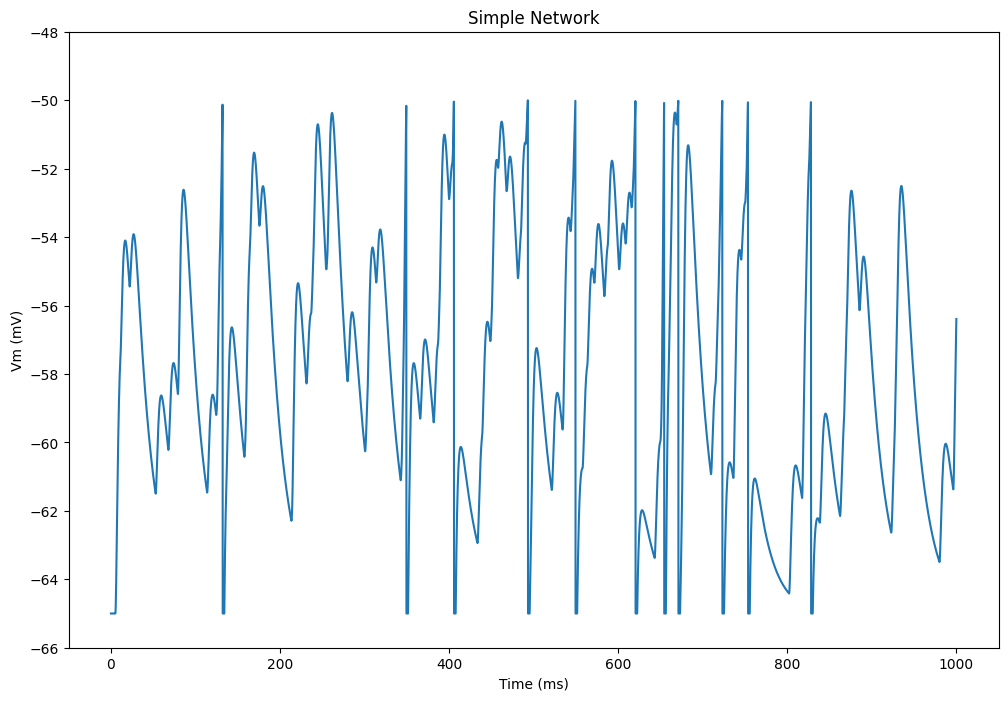

In [3]:
class IFCurrAlpha (ann.Network):

    def __init__(self, spike_times):

        # Input population
        inp  = self.create(ann.SpikeSourceArray(spike_times))

        # Output population
        pop = self.create(2, ann.IF_curr_alpha)
        pop.tau_refrac = 2.0
        pop.v_thresh = -50.0
        pop.tau_syn_E = 2.0
        pop.tau_syn_I = 2.0

        # Excitatory projection
        proj = self.connect(inp, pop, 'exc')
        proj.connect_all_to_all(weights=1.0)

        # Monitor
        self.m = self.monitor(pop, ['spike', 'v'])


# Parameters
tstop = 1000.0
rate = 100.0

# Create the Poisson spikes
number = int(2 * tstop * rate / 1000.0)
np.random.seed(26278342)
spike_times = list(np.add.accumulate(np.random.exponential(1000.0/rate, size=number)))

# Create the network
net = IFCurrAlpha(spike_times, dt=0.1)

# Compile the network
net.compile()

# Simulate
net.simulate(tstop)
data = net.m.get()

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(net.dt*np.arange(tstop/net.dt), data['v'][:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')
plt.ylim([-66.0, -48.0])
plt.title('Simple Network')
plt.show()

## IF_cond_exp

A single IF neuron with exponential, conductance-based synapses, fed by two spike sources.

This is a reimplementation of the PyNN example:

<http://www.neuralensemble.org/trac/PyNN/wiki/Examples/IF_cond_exp>

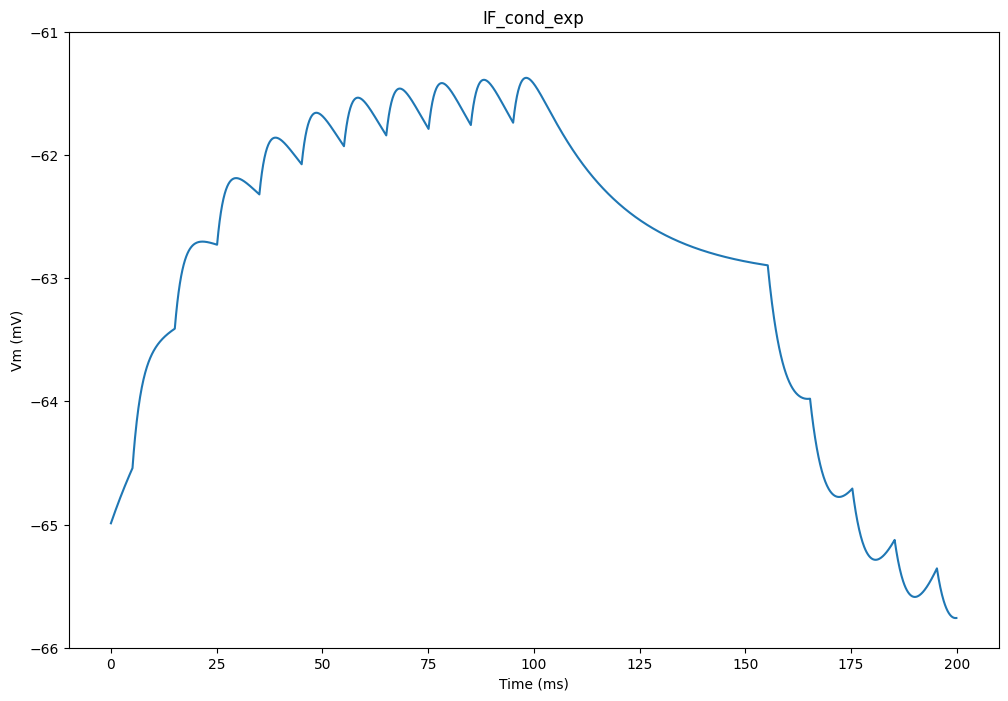

In [4]:
class IFCondExp (ann.Network):

    def __init__(self):

        # Input populations with predetermined spike times
        spike_sourceE = self.create(ann.SpikeSourceArray(
                spike_times= [float(i) for i in range(5, 105, 10)]
            )
        )
        spike_sourceI = self.create(ann.SpikeSourceArray(
                spike_times= [float(i) for i in range(155,255,10)]
            )
        )

        # Population with one IF_cond_exp neuron
        ifcell = self.create(1, ann.IF_cond_exp)
        ifcell.set(
            {   'i_offset' : 0.1,    'tau_refrac' : 3.0,
                'v_thresh' : -51.0,  'tau_syn_E'  : 2.0,
                'tau_syn_I': 5.0,    'v_reset'    : -70.0,
                'e_rev_E'  : 0.,     'e_rev_I'    : -80.0 } )


        # Projections
        connE = self.connect(spike_sourceE, ifcell, 'exc')
        connE.connect_all_to_all(weights=0.006, delays=2.0)

        connI = self.connect(spike_sourceI, ifcell, 'inh')
        connI.connect_all_to_all(weights=0.02,  delays=4.0)

        # Monitor
        self.n = self.monitor(spike_sourceE, ['spike'])
        self.m = self.monitor(ifcell, ['spike', 'v'])


# Parameters
tstop = 200.0

# Compile the network
net = IFCondExp(dt=0.1)
net.compile()

# Simulate
net.simulate(tstop)
data = net.m.get()

# Show the result
plt.figure(figsize=(12, 8))
plt.plot(net.dt * np.arange(tstop/net.dt), data['v'][:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')
plt.ylim([-66.0, -61.0])
plt.title('IF_cond_exp')
plt.show()

## EIF_cond_exp

Network of EIF neurons with exponentially decreasing conductance-based synapses.

This is a reimplementation of the Brian example:

<http://brian.readthedocs.org/en/1.4.1/examples-misc_expIF_network.html>

Compiling network 3...  OK 
Simulating 0.5 seconds of the network 3 took 0.1621229648590088 seconds. 


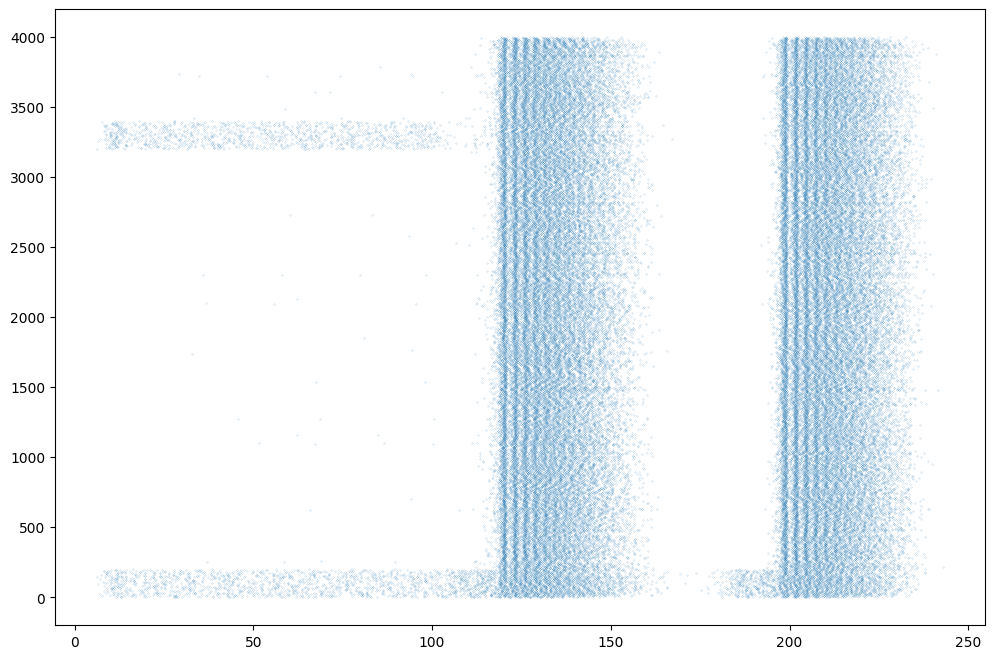

In [5]:
EIF = ann.Neuron(
    parameters = dict(
        v_rest = -70.0,
        cm = 0.2,
        tau_m = 10.0,
        tau_syn_E = 5.0,
        tau_syn_I = 10.0,
        e_rev_E = 0.0,
        e_rev_I = -80.0,
        delta_T = 3.0,
        v_thresh = -55.0,
        v_reset = -70.0,
        v_spike = -20.0,
    ),
    equations = [
        'dv/dt = (v_rest - v +  delta_T * exp( (v-v_thresh)/delta_T) )/tau_m + ( g_exc * (e_rev_E - v) + g_inh * (e_rev_I - v) )/cm',
        'tau_syn_E * dg_exc/dt = - g_exc',
        'tau_syn_I * dg_inh/dt = - g_inh',
    ],
    spike = "v > v_spike",
    reset = "v = v_reset",
    refractory = 2.0

)

# Create the network
net = ann.Network(dt=0.1)

# Poisson inputs
i_exc = net.create(ann.PoissonPopulation(geometry=200, rates="if t < 200.0 : 2000.0 else : 0.0"))
i_inh = net.create(ann.PoissonPopulation(geometry=200, rates="if t < 100.0 : 2000.0 else : 0.0"))

# Main population
P = net.create(geometry=4000, neuron=EIF)

# Subpopulations
Pe = P[:3200]
Pi = P[3200:]

# Projections
we = 1.5 / 1000.0 # excitatory synaptic weight
wi = 2.5 * we # inhibitory synaptic weight

Ce = net.connect(Pe, P, 'exc')
Ce.connect_fixed_probability(weights=we, probability=0.05)

Ci = net.connect(Pi, P, 'inh')
Ci.connect_fixed_probability(weights=wi, probability=0.05)

Ie = net.connect(i_exc, P[:200], 'exc') # inputs to excitatory cells
Ie.connect_one_to_one(weights=we)

Ii = net.connect(i_inh, P[3200:3400], 'exc')# inputs to inhibitory cells
Ii.connect_one_to_one(weights=we)

# Initialization of variables
P.v = -70.0 + 10.0 * np.random.rand(P.size)
P.g_exc = (np.random.randn(P.size) * 2.0 + 5.0) * we
P.g_inh = (np.random.randn(P.size) * 2.0 + 5.0) * wi

# Monitor
m = net.monitor(P, 'spike')

# Compile the Network
net.compile()

# Simulate
net.simulate(500.0, measure_time=True)

# Retrieve recordings
data = m.get()
t, n = m.raster_plot(data['spike'])

plt.figure(figsize=(12, 8))
plt.plot(t, n, '.', markersize=0.2)
plt.show()

## AEIF_cond_exp

Adaptive exponential integrate-and-fire model.

<http://www.scholarpedia.org/article/Adaptive_exponential_integrate-and-fire_model>

Model introduced in:

> Brette R. and Gerstner W. (2005), Adaptive Exponential Integrate-and-Fire Model as an Effective Description of Neuronal Activity, J. Neurophysiol. 94: 3637 - 3642.

This is a reimplementation of the Brian example:

<https://brian.readthedocs.io/en/stable/examples-frompapers_Brette_Gerstner_2005.html>

Compiling network 4...  OK 


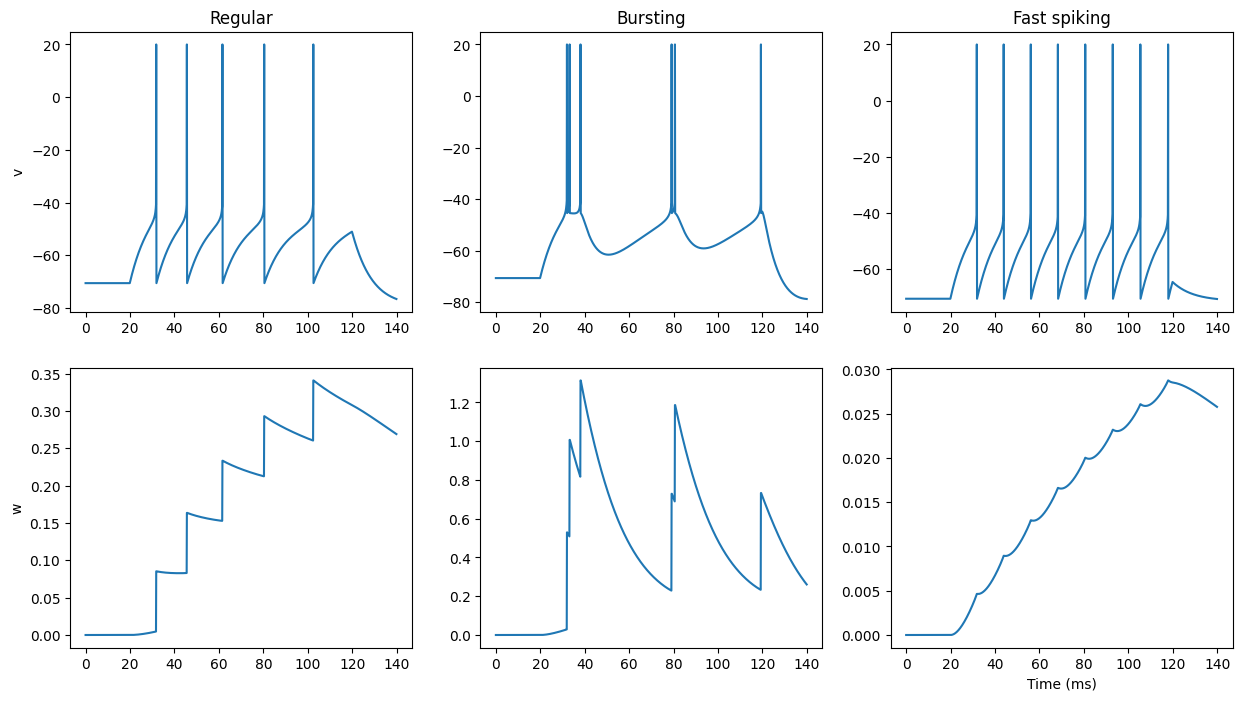

In [6]:
AEIF = ann.Neuron(
    parameters = dict(
        v_rest = -70.6,
        cm = 0.281, 
        tau_m = 9.3667, 
        tau_syn_E = 5.0,
        tau_syn_I = 5.0, 
        e_rev_E = 0.0,
        e_rev_I = -80.0,
        tau_w = ann.Parameter(144.0, locality='local'), 
        a = ann.Parameter(4.0, locality='local'),
        b = ann.Parameter(0.0805, locality='local'),
        i_offset = 0.0,
        delta_T = 2.0,
        v_thresh = -50.4,
        v_reset = ann.Parameter(-70.6, locality='local'),
        v_spike = -40.0,
    ), 
    equations = """
        I = g_exc * (e_rev_E - v) + g_inh * (e_rev_I - v) + i_offset            
        
        tau_m * dv/dt = (v_rest - v +  delta_T * exp((v-v_thresh)/delta_T)) + tau_m/cm*(I - w) : init=-70.6          
        tau_w * dw/dt = a * (v - v_rest) / 1000.0 - w           
        
        tau_syn_E * dg_exc/dt = - g_exc : exponential
        tau_syn_I * dg_inh/dt = - g_inh : exponential
    """,
    spike = "v > v_spike",
    reset = """
        v = v_reset
        w += b
    """,
    refractory = 0.1
)


# Create the network
net = ann.Network(dt=0.1)

# Population of 3 neurons (regular, bursting, fast spiking)
pop = net.create(geometry=3, neuron=AEIF)
pop.tau_w = [144., 20., 144.]
pop.a = [4. ,4., 2000.0*pop.cm/144.0]
pop.b = [0.0805, 0.5, 0.0]
pop.v_reset = [-70.6, pop.v_thresh + 5.0, -70.6]

m = net.monitor(pop, ['spike', 'v', 'w'])

# Compile the network
net.compile()

# Add current of 1 nA and simulate
net.simulate(20.0)
pop.i_offset = 1.0
net.simulate(100.0)
pop.i_offset = 0.0
net.simulate(20.0)

# Retrieve the results
data = m.get()

# Make spikes nicer
for i in range(3):
    if len(data['spike'][i]) > 0:
        data['v'][:, i][data['spike'][i]] = 20.0

# Plot the activity
plt.figure(figsize=(15, 8))
plt.subplot(2,3,1)
plt.plot(net.dt*np.arange(140.0/net.dt), data['v'][:, 0])
plt.title("Regular")
plt.ylabel('v')
plt.subplot(2,3,2)
plt.plot(net.dt*np.arange(140.0/net.dt), data['v'][:, 1])
plt.title("Bursting")
plt.subplot(2,3,3)
plt.plot(net.dt*np.arange(140.0/net.dt), data['v'][:, 2])
plt.title('Fast spiking')
plt.subplot(2,3,4)
plt.plot(net.dt*np.arange(140.0/net.dt), data['w'][:, 0])
plt.ylabel('w')
plt.subplot(2,3,5)
plt.plot(net.dt*np.arange(140.0/net.dt), data['w'][:, 1])
plt.subplot(2,3,6)
plt.plot(net.dt*np.arange(140.0/net.dt), data['w'][:, 2])
plt.xlabel('Time (ms)')
plt.show()

## Non-linear synapses

A single IF neuron with two non-linear NMDA synapses.

This is a reimplementation of the Brian example:

<http://brian.readthedocs.org/en/latest/examples-synapses_nonlinear_synapses.html>

Compiling network 5...  OK 


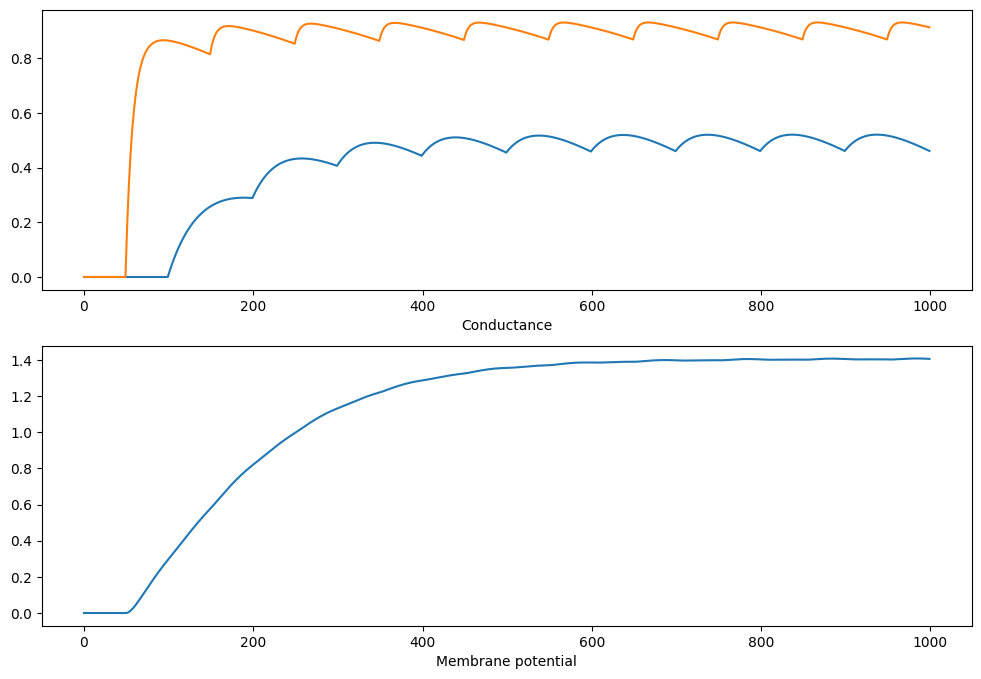

In [7]:
# Neurons
Linear = ann.Neuron(equations="dv/dt = 0.1", spike="v>1.0", reset="v=0.0")
Integrator = ann.Neuron(equations="dv/dt = 0.1*(g_exc -v)", spike="v>2.0", reset="v=0.0")

# Non-linear synapse
NMDA = ann.Synapse(
    parameters = dict(tau = 10.0),
    equations = [
        'tau * dx/dt = -x',
        'tau * dg/dt = -g +  x * (1 -g)',
    ],
    pre_spike = "x += w",
    psp = "g"
)

# Network
net = ann.Network(dt=0.1)

# Populations
input = net.create(geometry=2, neuron=Linear)
input.v = [0.0, 0.5]
pop = net.create(geometry=1, neuron=Integrator)

# Projection
proj = net.connect(pre=input, post=pop, target='exc', synapse=NMDA)
proj.connect_from_matrix(weights=[[1.0, 10.0]])

# Monitors
m = net.monitor(pop, 'v')
w = net.monitor(proj, 'g')

# Compile the network
net.compile()

# Simulate for 100 ms
net.simulate(100.0)

# Retrieve recordings
v = m.get('v')[:, 0]
s = w.get('g')[:, 0, :]

# Plot the recordings
plt.figure(figsize=(12, 8))

plt.subplot(2,1,1)
plt.plot(s[:, 0])
plt.plot(s[:, 1])
plt.xlabel("Time (ms)")
plt.xlabel("Conductance")

plt.subplot(2,1,2)
plt.plot(v)
plt.xlabel("Time (ms)")
plt.xlabel("Membrane potential")
plt.show()


## STP

Network (CUBA) with short-term synaptic plasticity for excitatory synapses (depressing at long timescales, facilitating at short timescales).

Adapted from :

<https://brian.readthedocs.io/en/stable/examples-synapses_short_term_plasticity2.html>

Compiling network 6...  OK 
Simulating 1.0 seconds of the network 6 took 0.0859217643737793 seconds. 
Total number of spikes: 14249


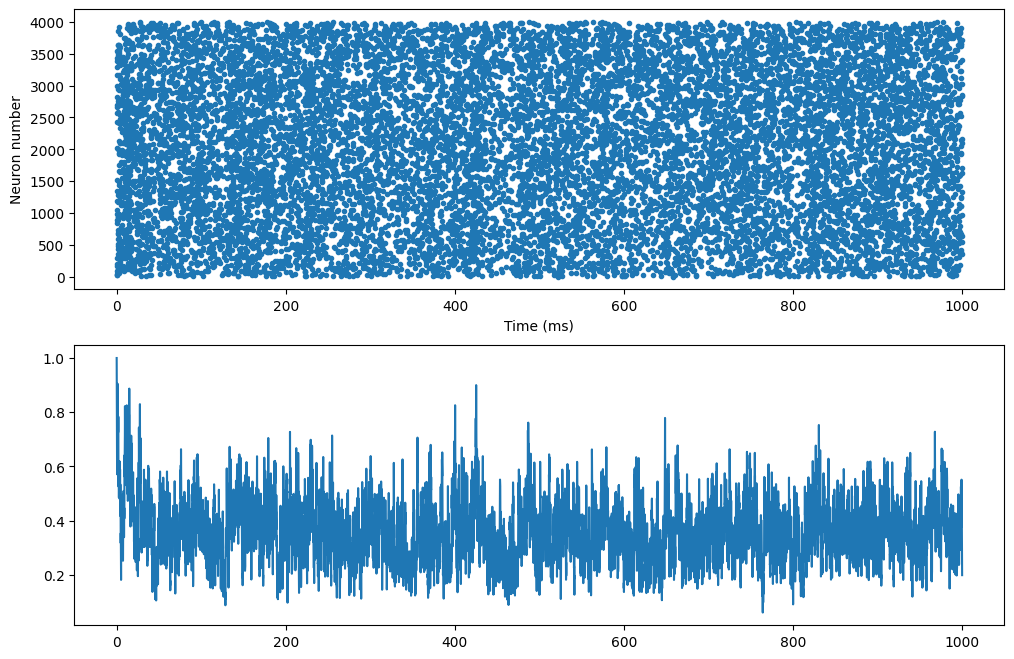

In [8]:
LIF = ann.Neuron(
    parameters = dict(
        tau_m = 20.0,
        tau_e = 5.0,
        tau_i = 10.0,
        E_rest = -49.0,
        E_thresh = -50.0,
        E_reset = -60.0,
    ),
    equations = [
        'tau_m * dv/dt = E_rest -v + g_exc - g_inh',
        'tau_e * dg_exc/dt = -g_exc',
        'tau_i * dg_inh/dt = -g_inh',
    ],
    spike = "v > E_thresh",
    reset = "v = E_reset"
)

STP = ann.Synapse(
    parameters = dict(
        tau_rec = 200.0,
        tau_facil = 20.0,
        U = 0.2,
    ),
    equations = [
        ann.Variable('dx/dt = (1 - x)/tau_rec', init = 1.0, method='event-driven'),
        ann.Variable('du/dt = (U - u)/tau_facil', init = 0.2, method='event-driven'),
    ],
    pre_spike = """
        g_target += w * u * x
        x *= (1 - u)
        u += U * (1 - u)
    """
)

# Network
net = ann.Network(dt=0.1)

# Population
P = net.create(geometry=4000, neuron=LIF)
P.v = ann.Uniform(-60.0, -50.0)
Pe = P[:3200]
Pi = P[3200:]

# Projections
con_e = net.connect(pre=Pe, post=P, target='exc', synapse = STP)
con_e.connect_fixed_probability(weights=1.62, probability=0.02)

con_i = net.connect(pre=Pi, post=P, target='inh')
con_i.connect_fixed_probability(weights=9.0, probability=0.02)

# Monitor
m = net.monitor(P, 'spike')

# Compile the network
net.compile()

# Simulate without plasticity
net.simulate(1000.0, measure_time=True)

data = m.get()
t, n = m.raster_plot(data['spike'])
rates = m.population_rate(data['spike'], 5.0)
print('Total number of spikes: ' + str(len(t)))

plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(t, n, '.')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron number')
plt.subplot(212)
plt.plot(np.arange(rates.size)*net.dt, rates)
plt.show()